Fully Connected (Dense) Variational Autoencoder 

Authored by David Luong

In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Model # for creating assembling a Neural Network model
from keras import Input # for instantiating a keras tensor and specifying input dimensions
from keras.layers import Dense, Lambda # adding layers to the Neural Network model
from tensorflow.keras.utils import plot_model # for plotting model diagram
from keras import backend as K # for access to Keras backend for reparameterization and creating custom loss function

# Data manipulation
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Visualization
import matplotlib 
import matplotlib.pyplot as plt # for plotting model loss
print('matplotlib: %s' % matplotlib.__version__) # print version
#import graphviz # for showing model diagram
#print('graphviz: %s' % graphviz.__version__) # print version
#import plotly
#import plotly.express as px # for data visualization
#print('plotly: %s' % plotly.__version__) # print version

#Import svm model
from sklearn import svm
#Import random forest model
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence

#Import knn model
from sklearn.neighbors import KNeighborsClassifier

# Final evaluation of the model
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score
from sklearn.naive_bayes import GaussianNB

# Other utilities
import sys
import os
import json
import random
from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
tf.random.set_seed(7)

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

Tensorflow/Keras: 2.7.0
numpy: 1.21.4
matplotlib: 3.5.0


Define Run Settings

In [2]:
# malware family
real_malware = 'Mixed' # OnLineGames, Renos, VBInject, WinWebSec, Zbot, Mixed

# data processing
use_harshit = 0 # 0 = use our samples, other to use Harshit's fake samples
unique_opcodes = 1 # 0 = visualize_explore/opcodes, 1 = fake_tests/opdicts

# VAE generator parameters
max_sequence_length = 600 # number of opcodes at the input layer (same as maximum length sequence)
latent_dim = 2 # latent space dimension
num_epochs = 30
num_batch_size = 16
use_trained_weights = 1 # 0 = train VAE, 1 = use saved train weights

# Classifier parameters
embedding_vector_length = 32
use_deep_classifiers = 1
run_classifiers = 1
use_kfold_deep_classifiers = 0
target_names = ['Authentic', 'Synthetic']
classify_test_size = 0.2

# save directory
fp = './results/vae_dense/'
write_opcode_files = 0
write_opcode_images = 0

# derived parameters
if real_malware == 'WinWebSec':
    fake_malware = 'wws'
    savedir_malware = 'wws'
    top_opcodes = 22
elif real_malware == 'OnLineGames':
    fake_malware = 'olgames'
    savedir_malware = 'olgames'
    top_opcodes = 22
elif real_malware == 'Renos':
    fake_malware = 'renos'
    savedir_malware = 'renos'
    top_opcodes = 22
elif real_malware == 'VBInject':
    fake_malware = 'vbinject'
    savedir_malware = 'vbinject'
    top_opcodes = 25
elif real_malware == 'Zbot':
    fake_malware = 'zbot'
    savedir_malware = 'zbot'
    top_opcodes = 20
elif real_malware == 'Mixed':
    fake_malware = 'mixed'
    savedir_malware = 'mixed'
    top_opcodes = 41
else:
    print('!!!Malware not found!!!')

Define Helper Functions

In [3]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# Python code to count the number of occurrences
def countX(lst, x):
    count = 0
    for ele in lst:
        if (ele == x):
            count = count + 1
    return count

# opcodes are indexed by overall frequency
def get_opcode_freq(opcode_frequency):
    rank = 0
    prev_count = -1
    for item in sorted(opcode_frequency,reverse=True):
        # increment rank if current opcode has different frequency than previous opcode
        if prev_count != item[0]:
            rank+=1
        # assign frequency rank
        opcode_frequency[item[1]] = rank
        # save previous frequency
        prev_count = item[0]
    return opcode_frequency

# opcodes are indexed by unique opcode position (opcodes_into_list)
def get_opcode_pos(data_into_list,opcodes_into_list):
    opcode_position = []
    nx = 0
    for x in data_into_list:
        ny = 0
        for y in opcodes_into_list:
            if x == y:
                opcode_position.append(ny)
                break
            ny+=1
        nx+=1
        # index for unknown opcodes
        if len(opcodes_into_list) == ny:
            opcode_position.append(ny)
    return opcode_position

# get opcode list from opdict
def get_opcode_dict(malware_fam,file_path):
    my_opcodes = file_path + 'opdict' + malware_fam + '.json'
    with open(my_opcodes) as json_file:
        data = json.load(json_file)
    return list(data.keys())

Load Real Malware Files

In [4]:
# initialize variables
dataset = []
dataset_names = []
dataset_ind = []

# opening list of unique opcodes
if unique_opcodes == 0:
    my_fp = './code/visualize_explore/opcodes/'
    my_opcodes = open(my_fp + 'opcodes' + real_malware + '.txt','r')
    opcodes = my_opcodes.read()
    opcodes_into_list = opcodes.replace('\n', ' ').split(" ")
    opcodes_into_list.remove('')
    # close opcodes file
    my_opcodes.close()
elif unique_opcodes == 1:
    my_fp = main_dir + '/code-20230116T073801Z-001/code/fake_tests/opdicts/'
    opcodes_into_list = get_opcode_dict(real_malware,my_fp)

# real malware parameters
my_filepath = "../malware_data/" + real_malware +'/'
dir_list = os.listdir(my_filepath)

# process real malware
for fm in dir_list:
    # if f == 'VirusShare_07c88839c083ddf7ecb11e7bfde38ea8.txt': # debug
    print('Processing real malware' + my_filepath + fm)

    # opening the file in read mode
    my_file = open(my_filepath + fm, "r")

    # reading the file
    data = my_file.read()

    # replacing end of line('/n') with ' ' and
    # splitting the text it further when '.' is seen.
    data_into_list = data.replace('\n', ' ').split(" ")
    
    # remove '' from opcodes
    data_into_list.remove('')
    
    opcode_frequency = []
    if len(data_into_list) >= max_sequence_length: # include malware with at least max_sequence_length number of opcodes
            
        # create (opcode frequency, rank) tuple
        idx = 0
        for x in opcodes_into_list:
            count = countX(data_into_list, x)
            #print('{} has occurred {} times'.format(x,count))
            opcode_frequency.append((count,idx))
            idx+=1
        # print(sorted(opcode_frequency,reverse=True))

        # opcodes are indexed by overall frequency
        opcode_frequency = get_opcode_freq(opcode_frequency)

        # opcodes are indexed by opcodes_into_list position
        opcode_position = get_opcode_pos(data_into_list,opcodes_into_list)

        # add real malware to dataset
        dataset.append(opcode_position)
        dataset_names.append(fm)
        dataset_ind.append(0) # 0 is indicator for real malware
    else:
        # skip processing if malware file is empty
        print('------------> is less than ' + str(max_sequence_length) + ' ... skipping')

    # close file
    my_file.close()

# convert dataset to numpy arrays
X = np.array(dataset,dtype=object)
y = np.array(dataset_ind,dtype='int64')

# print
nSamples = len(X)
print('There are', nSamples, 'malware files')

# write real malware to images
if write_opcode_images:
    print('Writing real malware images')
    tmp = sequence.pad_sequences(X, maxlen=max_sequence_length, dtype='int32',
        padding='pre', truncating='pre', value=0.)

    for idx,img in enumerate(tmp):
        plt.matshow(np.array(img).reshape(20,30))
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.savefig('./results/' + 'real_malware_images/' + savedir_malware + '/' + 'real_' + real_malware + '_' + str(idx+1) + '.png')
        plt.close()

Processing real malware../malware_data/Mixed/0009d99691e8eed99c7dd1500e07cda336d54260.asm.txt
Processing real malware../malware_data/Mixed/00113d9802cca3deba19cf9daa17f1c2269de2b8.asm.txt
------------> is less than 600 ... skipping
Processing real malware../malware_data/Mixed/002c3a4a12eb9cdc80754e4cddccbc98e5769392.asm.txt
Processing real malware../malware_data/Mixed/0036d720d8ff6c8f4860b5c69deba7c400e4d356.asm.txt
Processing real malware../malware_data/Mixed/0037c7716f1dc8e5c4e1f9a9f3e9d5aedb7a6979.asm.txt
Processing real malware../malware_data/Mixed/003824de7a82d2db9fc877c44ea93f76dd0e5ca9.asm.txt
Processing real malware../malware_data/Mixed/003c10125d80ba6cdbb05bc9aa047c7dbaa6b7ff.asm.txt
Processing real malware../malware_data/Mixed/00427746e03afb4d3b28791a82315e52acf66a0b.asm.txt
Processing real malware../malware_data/Mixed/00475573fe331e89916a27a9207f446bacfcf96a.asm.txt
Processing real malware../malware_data/Mixed/004bb59ba37917bfea49e6904f0551df7b3c719f.asm.txt
Processing real 

Define Training and Testing Datasets

In [5]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# truncate and pad input sequences
X_train = sequence.pad_sequences(X_train, maxlen=max_sequence_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_sequence_length)

# reshape and normalize
norm_factor = 1/(len(opcodes_into_list)+1)
sample_size = X_train.shape[0]
time_steps = X_train.shape[1]
X_train_reshaped = X_train.reshape(sample_size, time_steps)*norm_factor

sample_size = X_test.shape[0]
time_steps = X_test.shape[1]
X_test_reshaped = X_test.reshape(sample_size, time_steps)*norm_factor


In [6]:
#--- Create a function, which we will use to randomly sample from latent space distribution
# Note, epsilon is sampled from a standard normal distribution and is used to maintain the required stochasticity of Z
# Meanwhile, z-mean and z-sigma remain deterministic allowing the loss to backpropagate through the layers.
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

Define Encoder

In [7]:
# ********** Create Encoder **********

#--- Input Layer 
visible = keras.Input(shape=(max_sequence_length,), name='Encoder-Input-Layer')

#--- Hidden Layer
h_enc1 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)

#--- Custom Latent Space Layer
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3) # Mean component
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3) # Standard deviation component
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

#--- Create Encoder model
encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

# Display model diagram
encoder.summary()
#plot_model(encoder, show_shapes=True, dpi=300)

Model: "Encoder-Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder-Input-Layer (InputLaye  [(None, 600)]       0           []                               
 r)                                                                                               
                                                                                                  
 Encoder-Hidden-Layer-1 (Dense)  (None, 64)          38464       ['Encoder-Input-Layer[0][0]']    
                                                                                                  
 Encoder-Hidden-Layer-2 (Dense)  (None, 16)          1040        ['Encoder-Hidden-Layer-1[0][0]'] 
                                                                                                  
 Encoder-Hidden-Layer-3 (Dense)  (None, 8)           136         ['Encoder-Hidden-Laye

Define Decoder

In [8]:
# ********** Create Decoder **********

#--- Input Layer 
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

#--- Hidden Layer
h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)

#--- Output Layer
outputs = Dense(max_sequence_length, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

#--- Create Decoder model
decoder = Model(latent_inputs, outputs, name='Decoder-Model')

# Display model diagram
decoder.summary()
#plot_model(decoder, show_shapes=True, dpi=300)

Model: "Decoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Z-Sampling (InputLaye  [(None, 2)]              0         
 r)                                                              
                                                                 
 Decoder-Hidden-Layer-1 (Den  (None, 8)                24        
 se)                                                             
                                                                 
 Decoder-Hidden-Layer-2 (Den  (None, 16)               144       
 se)                                                             
                                                                 
 Decoder-Hidden-Layer-3 (Den  (None, 64)               1088      
 se)                                                             
                                                                 
 Decoder-Output-Layer (Dense  (None, 600)            

Define VAE Model

In [9]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = decoder(encoder(visible)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

Define VAE Loss Function

In [10]:
# Reconstruction loss compares inputs and outputs and tries to minimise the difference
r_loss = max_sequence_length * keras.losses.mse(visible, outpt)  # use MSE

# KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

# The VAE loss is a combination of reconstruction loss and KL loss
vae_loss = K.mean(r_loss + kl_loss)

# Add loss to the model and compile it
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Train the VAE and Plot Loss Function

In [11]:
if use_trained_weights:
    print('Using trained weights')
    load_status = vae.load_weights(fp + 'weights/'+fake_malware+'/my_weights_'+real_malware+'.h5')
else:
    # Train VAE model
    history = vae.fit(X_train_reshaped, y_train, epochs=num_epochs, batch_size=num_batch_size, validation_data=(X_test_reshaped, y_test))

    # Plot a loss chart
    fig, ax = plt.subplots(figsize=(16,9), dpi=300)
    plt.title(label='Model Loss by Epoch', loc='center')

    ax.plot(history.history['loss'], label='Training Data', color='black')
    ax.plot(history.history['val_loss'], label='Validation Data', color='red')
    ax.set(xlabel='Epoch', ylabel='Loss')
    plt.xticks(ticks=np.arange(len(history.history['loss']), step=5), labels=np.arange(0, len(history.history['loss']), step=5))
    plt.legend()

    # save loss chart
    print('Saved loss chart')
    plt.savefig(fp+'my_loss_chart_'+real_malware+'.png')
    plt.show()

    # save weights
    print('Saved weights')
    vae.save_weights(fp+'weights/'+fake_malware+'/my_weights_'+real_malware+'.h5')

Using trained weights


Visualize the Latent Space

Saved latent space chart


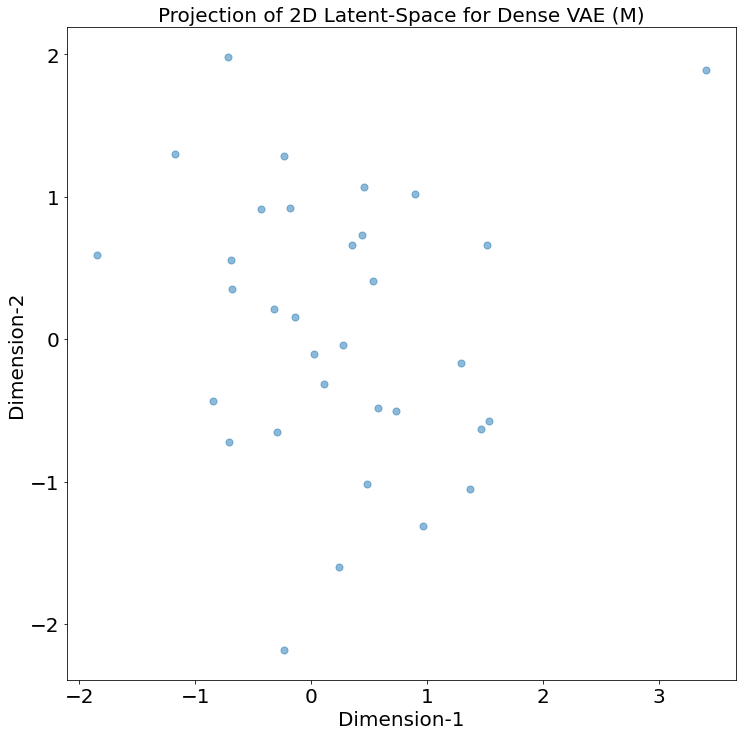

In [12]:
a,b,c = encoder.predict(X_train_reshaped)
embeddings = sampling([a, b])

mu = np.mean(a)
sig = np.sqrt(abs(np.mean(b)))

figsize = 12
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0] , embeddings[:, 1], alpha=0.5, s=50)
plt.xlabel("Dimension-1", size=20)
plt.ylabel("Dimension-2", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title("Projection of 2D Latent-Space for Dense VAE (" + real_malware[0] +")", size=20)

# save latent space chart
print('Saved latent space chart')
plt.savefig(fp+'my_latent_chart_'+real_malware+'.png')

plt.show()

[Disabled] Another Way to Visualize Latent Space

In [13]:
# Use encoder model to encode inputs into a latent space
#X_test_encoded = encoder.predict(X_test)

# Recall that our encoder returns 3 arrays: z-mean, z-log-sigma and z. We plot the values for z
# Create a scatter plot
#fig = px.scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1], 
#                 opacity=1, color=y_test.astype(str))

# Change chart background color
#fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
#fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', 
#                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
#                 showline=True, linewidth=1, linecolor='white',
#                 title_font=dict(size=10), tickfont=dict(size=10))
#
#fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', 
#                 zeroline=True, zerolinewidth=1, zerolinecolor='white', 
#                 showline=True, linewidth=1, linecolor='white',
#                 title_font=dict(size=10), tickfont=dict(size=10))

# Set figure title
#fig.update_layout(title_text="MNIST digit representation in the 2D Latent Space")

# Update marker size
#fig.update_traces(marker=dict(size=2))

#fig.show()

Generate Fake Malware

In [14]:
for nF in range(nSamples):
    randomlist = []
    for i in range(0,latent_dim):
        #n = random.randint(0,len(opcodes_into_list))
        #n = (random.random() - 0.5)*2
        #n = random.random()
        #n = 2*random.random()-1
        n = np.random.normal(mu, sig)
        randomlist.append(n)
    z_sample_opcode=[randomlist]

    # Decode latent inputs (i.e., generate new outputs)
    opcode_decoded = decoder.predict(z_sample_opcode)

    tmp = np.rint(opcode_decoded.reshape(20,30)*len(opcodes_into_list)).astype(int)

    if write_opcode_files:
    # write opcode integers
        my_opcodes = open(fp + 'samples' + '/' + fake_malware + '/' + 'generated_' + real_malware + '_' + str(nF+1) + '.txt','a+')

        for row in tmp:
            for col in row:
                my_opcodes.write(str(col))
                my_opcodes.write('\n')
        # close opcodes file
        my_opcodes.close()

    if write_opcode_images:
        # Reshape and display/save the image
        plt.matshow(tmp)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.savefig(fp + 'images/' + savedir_malware + '/' + 'generated_' + real_malware + '_' + str(nF+1) + '.png')
        plt.close()
    
    # append to fake malware to dataset
    dataset.append(tmp.reshape(1,max_sequence_length)[0])
    dataset_ind.append(1)

Classifier Models

In [74]:
def lstm(X, y, real_malware, target_names, max_sequence_length, embedding_vector_length, num_unique, classify_test_size):
    classifier_name = 'LSTM'
    print('******%s******' % classifier_name)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=classify_test_size, shuffle=True)
    clf = Sequential()
    clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
    clf.add(LSTM(100))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
    clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
    scores = clf.evaluate(X_test, y_test, verbose=1)
    accuracy = scores[1]
    y_pred = np.round(clf.predict(X_test))
    precision = precision_score(y_test, y_pred)
    recall= recall_score(y_test, y_pred)

    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return accuracy, precision, recall#, class_report

def lstm_kfold(X, y, real_malware, target_names, max_sequence_length, embedding_vector_length, num_unique, classify_test_size):
    classifier_name = 'Kfold LSTM'
    print('******%s******' % classifier_name)
    k = int(1/classify_test_size)
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True, random_state=18245)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # build LSTM model
        clf = Sequential()
        clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
        clf.add(LSTM(100))
        clf.add(Dense(1, activation='sigmoid'))
        clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
        clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
        scores = clf.evaluate(X_test, y_test, verbose=1)
        acc = scores[1]
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = np.round(clf.predict(X_test))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\n%s accuracy: ' % classifier_name, accuracy)
    print('%s precision: ' % classifier_name, precision)
    print('%s recall: ' % classifier_name, recall)
    
    print('\nAvg %s accuracy: %0.2f'% (classifier_name, np.mean(np.array(accuracy))))
    print('Avg %s precision: %0.2f'% (classifier_name, np.mean(np.array(precision))))
    print('Avg %s recall: %0.2f\n'% (classifier_name ,np.mean(np.array(recall))))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = Sequential()
    clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
    clf.add(LSTM(100))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
    clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
    y_pred = np.round(clf.predict(X_test))
    
    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return np.mean(np.array(accuracy)), np.mean(np.array(precision)), np.mean(np.array(recall))#, class_report

def bi_lstm(X, y, real_malware, target_names, max_sequence_length, embedding_vector_length, num_unique, classify_test_size):
    classifier_name = 'Bidirectional_LSTM'
    print('******%s******' % classifier_name)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=classify_test_size, shuffle=True)
    clf = Sequential()
    clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
    #clf.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    clf.add(Bidirectional(LSTM(100, dropout=0.2)))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
    clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
    scores = clf.evaluate(X_test, y_test, verbose=1)
    accuracy = scores[1]
    y_pred = np.round(clf.predict(X_test))
    precision = precision_score(y_test, y_pred)
    recall= recall_score(y_test, y_pred)

    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return accuracy, precision, recall#, class_report

def bi_lstm_kfold(X, y, real_malware, target_names,max_sequence_length, embedding_vector_length, num_unique, classify_test_size):
    classifier_name = 'Kfold Bidirectional_LSTM'
    print('******%s******' % classifier_name)
    k = int(1/classify_test_size)
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True, random_state=18245)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # build LSTM model
        clf = Sequential()
        clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
        #clf.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
        clf.add(Bidirectional(LSTM(100, dropout=0.2)))
        clf.add(Dense(1, activation='sigmoid'))
        clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
        clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
        scores = clf.evaluate(X_test, y_test, verbose=1)
        acc = scores[1]
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = np.round(clf.predict(X_test))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\n%s accuracy: ' % classifier_name, accuracy)
    print('%s precision: ' % classifier_name, precision)
    print('%s recall: ' % classifier_name, recall)
    
    print('\nAvg %s accuracy: %0.2f'% (classifier_name, np.mean(np.array(accuracy))))
    print('Avg %s precision: %0.2f'% (classifier_name, np.mean(np.array(precision))))
    print('Avg %s recall: %0.2f\n'% (classifier_name ,np.mean(np.array(recall))))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = Sequential()
    clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
    #clf.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
    clf.add(Bidirectional(LSTM(100, dropout=0.2)))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
    clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
    y_pred = np.round(clf.predict(X_test))
    
    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return np.mean(np.array(accuracy)), np.mean(np.array(precision)), np.mean(np.array(recall))#, class_report

def cnn_lstm(X, y, real_malware, target_names, max_sequence_length, embedding_vector_length, num_unique, classify_test_size):
    classifier_name = 'CNN_LSTM'
    print('******%s******' % classifier_name)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=classify_test_size, shuffle=True)
    clf = Sequential()
    clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
    clf.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    clf.add(MaxPooling1D(pool_size=2))
    clf.add(LSTM(100))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
    clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
    scores = clf.evaluate(X_test, y_test, verbose=1)
    accuracy = scores[1]
    y_pred = np.round(clf.predict(X_test))
    precision = precision_score(y_test, y_pred)
    recall= recall_score(y_test, y_pred)

    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return accuracy, precision, recall#, class_report

def cnn_lstm_kfold(X, y, real_malware, target_names,max_sequence_length, embedding_vector_length, num_unique, classify_test_size):
    classifier_name = 'Kfold CNN_LSTM'
    print('******%s******' % classifier_name)
    k = int(1/classify_test_size)
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True, random_state=18245)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # build LSTM model
        clf = Sequential()
        clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
        clf.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
        clf.add(MaxPooling1D(pool_size=2))
        clf.add(LSTM(100))
        clf.add(Dense(1, activation='sigmoid'))
        clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
        clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
        scores = clf.evaluate(X_test, y_test, verbose=1)
        acc = scores[1]
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = np.round(clf.predict(X_test))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\n%s accuracy: ' % classifier_name, accuracy)
    print('%s precision: ' % classifier_name, precision)
    print('%s recall: ' % classifier_name, recall)
    
    print('\nAvg %s accuracy: %0.2f'% (classifier_name, np.mean(np.array(accuracy))))
    print('Avg %s precision: %0.2f'% (classifier_name, np.mean(np.array(precision))))
    print('Avg %s recall: %0.2f\n'% (classifier_name ,np.mean(np.array(recall))))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = Sequential()
    clf.add(Embedding(num_unique, embedding_vector_length, input_length=max_sequence_length))
    clf.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    clf.add(MaxPooling1D(pool_size=2))
    clf.add(LSTM(100))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01, patience=10, restore_best_weights=True)
    clf.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, callbacks=[callback], verbose=1)
    y_pred = np.round(clf.predict(X_test))
    
    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return np.mean(np.array(accuracy)), np.mean(np.array(precision)), np.mean(np.array(recall))#, class_report

def support_vector_machine(X, y, real_malware, target_names, max_sequence_length, classify_test_size):
    classifier_name = 'Support Vector Machines'
    print('******%s******' % classifier_name)
    k = int(1/classify_test_size)
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = svm.SVC(C=5, kernel='rbf')
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = clf.predict(X_test)
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\n%s accuracy: ' % classifier_name, accuracy)
    print('%s precision: ' % classifier_name, precision)
    print('%s recall: ' % classifier_name, recall)
    
    print('\nAvg %s accuracy: %0.2f'% (classifier_name, np.mean(np.array(accuracy))))
    print('Avg %s precision: %0.2f'% (classifier_name, np.mean(np.array(precision))))
    print('Avg %s recall: %0.2f\n'% (classifier_name ,np.mean(np.array(recall))))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = svm.SVC(C=5, kernel='rbf')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return np.mean(np.array(accuracy)), np.mean(np.array(precision)), np.mean(np.array(recall))#, class_report

def random_forest(X, y, real_malware, target_names, max_sequence_length, classify_test_size):
    classifier_name = 'Random Forest'
    print('******%s******' % classifier_name)
    k = int(1/classify_test_size)
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True, random_state=6357)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = RandomForestClassifier(n_estimators=50, max_depth=5)
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = clf.predict(X_test)
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\n%s accuracy: ' % classifier_name, accuracy)
    print('%s precision: ' % classifier_name, precision)
    print('%s recall: ' % classifier_name, recall)
    
    print('\nAvg %s accuracy: %0.2f'% (classifier_name, np.mean(np.array(accuracy))))
    print('Avg %s precision: %0.2f'% (classifier_name, np.mean(np.array(precision))))
    print('Avg %s recall: %0.2f\n'% (classifier_name ,np.mean(np.array(recall))))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = RandomForestClassifier(n_estimators=50, max_depth=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return np.mean(np.array(accuracy)), np.mean(np.array(precision)), np.mean(np.array(recall))#, class_report

def k_nearest_neighbors(X, y, real_malware, target_names, max_sequence_length, classify_test_size):
    classifier_name = 'K-Nearest Neighbors'
    print('******%s******' % classifier_name)
    k = int(1/classify_test_size)
    accuracy = []
    precision = []
    recall = []
    best = 0.
    kf = KFold(n_splits=k, shuffle=True, random_state=18245)

    # truncate and pad input sequences
    X = sequence.pad_sequences(X, maxlen=max_sequence_length)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = KNeighborsClassifier(n_neighbors=1, p=2)
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accuracy.append(acc)
        if acc>best:
            best = acc
            best_train, best_test = train_index, test_index
            
        y_pred = clf.predict(X_test)
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        
    print('\n%s accuracy: ' % classifier_name, accuracy)
    print('%s precision: ' % classifier_name, precision)
    print('%s recall: ' % classifier_name, recall)
    
    print('\nAvg %s accuracy: %0.2f'% (classifier_name, np.mean(np.array(accuracy))))
    print('Avg %s precision: %0.2f'% (classifier_name, np.mean(np.array(precision))))
    print('Avg %s recall: %0.2f\n'% (classifier_name ,np.mean(np.array(recall))))
    
    X_train, X_test, y_train, y_test = X[best_train], X[best_test], y[best_train], y[best_test]
    clf = KNeighborsClassifier(n_neighbors=1, p=2)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    show_confusion_matrix = False
    if show_confusion_matrix:
        fig, ax = plt.subplots(figsize=(4,4))
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=np.array(target_names), cmap=plt.cm.Blues, ax=ax)
        ax.set_title('%s Confusion Matrix \n using %s'%(real_malware,classifier_name))
        plt.show()
    
    #class_report = classification_report(y_test, y_pred, target_names=target_names) 

    return np.mean(np.array(accuracy)), np.mean(np.array(precision)), np.mean(np.array(recall))#, class_report

Classify Real and Fake Malware

In [54]:
def get_classification(dataset, dataset_ind ,mw_classify_size):
    # convert dataset to numpy arrays
    X_classify = np.array(dataset,dtype=object)
    y_classify = np.array(dataset_ind,dtype='int64')
    
    # choose malware sample subset for training
    mw_classify_idx = np.random.permutation(len(X_classify))[:mw_classify_size]
    X_train = X_classify[mw_classify_idx]
    y_train = y_classify[mw_classify_idx]

    # truncate and pad input sequences
    X_train = sequence.pad_sequences(X_train, maxlen=max_sequence_length)

    # create LSTM model

    if use_deep_classifiers:

        if use_kfold_deep_classifiers:
            # Kfold LSTM classifiers
            print('Running Kfold Deep Classifiers')
            lstm_accuracy, lstm_precision, lstm_recall = lstm_kfold(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
            bi_lstm_accuracy, bi_lstm_precision, bi_lstm_recall = bi_lstm_kfold(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
            cnn_lstm_accuracy, cnn_lstm_precision, cnn_lstm_recall = cnn_lstm_kfold(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
        else:
            # Standard LSTM classifiers
            print('Running Deep Classifiers')
            lstm_accuracy, lstm_precision, lstm_recall = lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
            bi_lstm_accuracy, bi_lstm_precision, bi_lstm_recall = bi_lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
            cnn_lstm_accuracy, cnn_lstm_precision, cnn_lstm_recall = cnn_lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)

    svm_accuracy, svm_precision, svm_recall = support_vector_machine(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
    rf_accuracy, rf_precision, rf_recall = random_forest(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
    knn_accuracy, knn_precision, knn_recall = k_nearest_neighbors(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
    
    print('Classification on ' + str(int(classify_test_size*len(X_train))) + ' Authentic and Synthetic Dense VAE Samples from the ' + real_malware + ' Malware Family')
    print('-------------------------------------------------------------')

    print("                               Accuracy    Precison    Recall")
    print("SVM Score:                     %0.2f        %0.2f        %0.2f  " % (svm_accuracy, svm_precision, svm_recall))
    print("Random Forest Score:           %0.2f        %0.2f        %0.2f  " % (rf_accuracy, rf_precision, rf_recall))
    print("k-Nearest Neighbor Score:      %0.2f        %0.2f        %0.2f  " % (knn_accuracy, knn_precision, knn_recall))

    if use_deep_classifiers:
        print("Standard LSTM Score:           %0.2f        %0.2f        %0.2f  " % (lstm_accuracy, lstm_precision, lstm_recall))
        print("Bidirectional LSTM Score:      %0.2f        %0.2f        %0.2f  " % (bi_lstm_accuracy, bi_lstm_precision, bi_lstm_recall))
        print("CNN LSTM Score:                %0.2f        %0.2f        %0.2f  " % (cnn_lstm_accuracy, cnn_lstm_precision, cnn_lstm_recall))

        list_accuracy = [svm_accuracy, rf_accuracy, knn_accuracy, lstm_accuracy, bi_lstm_accuracy, cnn_lstm_accuracy]
        list_precision = [svm_precision, rf_precision, knn_precision, lstm_precision, bi_lstm_precision, cnn_lstm_precision]
        list_recall = [svm_recall, rf_recall, knn_recall, lstm_recall, bi_lstm_recall, cnn_lstm_recall]
    else:
        list_accuracy = [svm_accuracy, rf_accuracy, knn_accuracy]
        list_precision = [svm_precision, rf_precision, knn_precision]
        list_recall = [svm_recall, rf_recall, knn_recall]
    print("=============================================================")
    print("Average Score:                 %0.2f        %0.2f        %0.2f  " % (sum(list_accuracy)/len(list_accuracy), sum(list_precision)/len(list_precision), sum(list_recall)/len(list_recall)))
    print("=============================================================")

    return sum(list_accuracy)/len(list_accuracy)

In [103]:
# choose standard or min-sample classification
run_min_samples = 0

# standard classification parameters
list_classifiers = ['all'] #['svm','rf','knn','lstm','bi-lstm','cnn-lstm', 'all']
mw_classify_size = 50 # requested malware samples for classifier training (capped at number of samples used for VAE training)

# min-sample classification parameters
target_score = 0.95
LOW_SAMPLE_BOUND = 10
HIGH_SAMPLE_BOUND = mw_classify_size

classifier_min_samples = []
classifier_min_sample_scores = []

for select_classifier in list_classifiers:

    if run_classifiers:

        current_score = 1.0

        # run custom classification for min samples achieving min accuracy
        if run_min_samples:

            counter = 0
            low_sample = LOW_SAMPLE_BOUND
            high_sample = HIGH_SAMPLE_BOUND
            current_sample = high_sample #(low_sample+high_sample)//2
            list_samples = []
        
            while current_score > target_score and counter < 10:

                # convert dataset to numpy arrays
                X_classify = np.array(dataset,dtype=object)
                y_classify = np.array(dataset_ind,dtype='int64')
                
                # choose malware sample subset for training
                mw_classify_idx = np.random.permutation(len(X_classify))[:current_sample]
                X_train = X_classify[mw_classify_idx]
                y_train = y_classify[mw_classify_idx]

                # truncate and pad input sequences
                X_train = sequence.pad_sequences(X_train, maxlen=max_sequence_length)

                # select classifier(s)
                if select_classifier == 'svm':
                    current_score, precision, recall = support_vector_machine(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
                elif select_classifier == 'rf': 
                    current_score, precision, recall = random_forest(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
                elif select_classifier == 'knn': 
                    current_score, precision, recall = k_nearest_neighbors(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
                elif select_classifier == 'lstm': 
                    current_score, precision, recall = lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
                elif select_classifier == 'bi-lstm': 
                    current_score, precision, recall = bi_lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
                elif select_classifier == 'cnn-lstm': 
                    current_score, precision, recall = cnn_lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
                elif select_classifier == 'all': 
                    # all classifiers
                    current_score = get_classification(dataset, dataset_ind, current_sample)
                else:
                    print('Error: Unknown Classifier')

                # Debug
                #print(counter, low_sample, current_sample, high_sample, current_score)

                # keep track of samples that are above target_score
                if current_score > target_score:
                    list_samples.append(current_sample)
                
                if current_score > target_score:
                    high_sample = current_sample # search upper samples
                else:
                    low_sample = current_sample # search lower samples

                # End and prepare for next search iteration
                counter += 1
                current_sample = (low_sample+high_sample)//2

                # Debug
                #print('Current Score = ', str(current_score))
                #print('Target Score = ', str(target_score))
                #print('Current Counter = ', str(counter))
                #print('Current Sample = ', str(current_sample))

                # Stop conditions
                if current_sample == HIGH_SAMPLE_BOUND - 1 or current_sample == LOW_SAMPLE_BOUND + 1:
                    print('Reached final sample near bounds')
                    break 
            
            # report conclusion
            if list_samples:
                min_sample = min(list_samples)
                print("Min Sample Size: ", min_sample)
            else:
                print("No samples can reach target score")
                print('Current Score = ', str(current_score))
                min_sample = -1
            
            # save min samples
            classifier_min_samples.append(min_sample)
            classifier_min_sample_scores.append(current_score)
        
        # Run standard classification
        else:
            # select classifier(s)
            if select_classifier == 'svm':
                current_score, precision, recall = support_vector_machine(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
            elif select_classifier == 'rf': 
                current_score, precision, recall = random_forest(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
            elif select_classifier == 'knn': 
                current_score, precision, recall = k_nearest_neighbors(X_train, y_train, real_malware, target_names, max_sequence_length, classify_test_size)
            elif select_classifier == 'lstm': 
                current_score, precision, recall = lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
            elif select_classifier == 'bi-lstm': 
                current_score, precision, recall = bi_lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
            elif select_classifier == 'cnn-lstm': 
                current_score, precision, recall = cnn_lstm(X_train, y_train, real_malware, target_names, max_sequence_length, embedding_vector_length, top_opcodes, classify_test_size)
            elif select_classifier == 'all': 
                # all classifiers
                current_score = get_classification(dataset, dataset_ind, mw_classify_size)
            else:
                print('Error: Unknown Classifier')
    
if run_min_samples:
    print('===================================')
    print('Classifiers: ', list_classifiers)
    print('Min Samples for at least', str(target_score), 'Accuracy:', classifier_min_samples)
    print('Min Sample Scores Accuracy:', classifier_min_sample_scores)
    print('===================================')
    

Running Deep Classifiers
******LSTM******
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6948 - accuracy: 0.6250 - val_loss: 0.7002 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 342ms/step - loss: 0.6868 - accuracy: 0.7500 - val_loss: 0.7044 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 355ms/step - loss: 0.6790 - accuracy: 0.7500 - val_loss: 0.7089 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 369ms/step - loss: 0.6707 - accuracy: 0.7500 - val_loss: 0.7142 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 341ms/step - loss: 0.6614 - accuracy: 0.7500 - val_loss: 0.7204 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 349ms/step - loss: 0.6503 - accuracy: 0.7500 - val_loss: 0.7283 - val_accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 0s 347ms/step - loss: 0.6365 - accuracy:

C:\Users\e399410\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\e399410\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


******Bidirectional_LSTM******
Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.6882 - accuracy: 0.8750 - val_loss: 0.6825 - val_accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - 0s 411ms/step - loss: 0.6803 - accuracy: 1.0000 - val_loss: 0.6763 - val_accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - 0s 434ms/step - loss: 0.6723 - accuracy: 1.0000 - val_loss: 0.6694 - val_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 442ms/step - loss: 0.6646 - accuracy: 1.0000 - val_loss: 0.6610 - val_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 1s 546ms/step - loss: 0.6559 - accuracy: 1.0000 - val_loss: 0.6511 - val_accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 480ms/step - loss: 0.6441 - accuracy: 1.0000 - val_loss: 0.6386 - val_accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 491ms/step - loss: 0.6315 - accuracy: 1.0000 - val_loss: 0.6228 - val_ac

C:\Users\e399410\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\e399410\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
